In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.lib.recfunctions import append_fields
from params import *
from process_datasets import *
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

In [2]:
all_features = ['articulation_feature.kor', 'asynchrony_feature.delta', 'asynchrony_feature.pitch_cor', 'asynchrony_feature.vel_cor', 'asynchrony_feature.voice_std', 
                'dynamics_feature.agreement', 'dynamics_feature.consistency_std', 'dynamics_feature.ramp_cor', 'dynamics_feature.tempo_cor', 
                'pedal_feature.onset_value', 'pedal_feature.offset_value', 'pedal_feature.to_prev_release', 'pedal_feature.to_next_release', 
                'pedal_feature.average_pedal', 'pedal_feature.pedal_coverage']

In [72]:
def plot_by_dataset(dataset="ASAP", attri="articulation_feature.kor", level="piece", col="composer", hue=None, filter=None):
    """plot the overall distribution of each attributes from the dataset. 
    load the performance features as numpy structured array list, with optional metadata.

    Args:
        dataset (str): dataset to use. Defaults to "ASAP".
    """

    pf, meta_dict = load_dataset_pf(datasets=[dataset], return_metadata=True)
    
    if level == "piece":
        # get piece-level attributes and append the metadata
        pf_piece_concat = pd.concat([pd.DataFrame(feats).mean().to_frame().T for feats in pf], ignore_index=True)
        pf_piece_concat['composer'] = meta_dict['composer']
        pf_piece_concat['performer'] = meta_dict['performer']
        pf_plot_data = pf_piece_concat
    elif level == "note":
        pf = [pd.DataFrame(feats) for feats in pf]
        for i, feats in enumerate(pf):
            feats['composer'] = meta_dict['composer'][i]
            feats['performer'] = meta_dict['performer'][i]
        pf_note_concat = pd.concat(pf, ignore_index=True)
        pf_plot_data = pf_note_concat  

    if dataset == "ASAP" and (isinstance(filter, list)):
        for item in filter:
            pf_plot_data = pf_plot_data[pf_plot_data['composer'] != item]

    sns.set_style("darkgrid")

    g = sns.FacetGrid(pf_plot_data, col=col, col_wrap=4)
    g.map(sns.histplot, attri, stat="probability", common_norm=False, bins=20)
    g.fig.subplots_adjust(top=0.9)
    # g.fig.suptitle(f"{dataset} dataset distribution of {attri} by composer, {level} level", fontsize=16)

def plot_datasets(datasets=["ASAP", "VIENNA422", "BMZ"], attri="articulation_feature.kor", level="piece", 
                  selected_hue=[],
                  pf=None, meta_dict=None):
    """plot the overall distribution of each attributes from the datasets. 
    load the performance features as numpy structured array list, with optional metadata.

    Args:
        datasets (list): datasets to use. Defaults to ["ASAP"].
    """
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.rcParams['font.size'] = 16
    sns.set_style("darkgrid")

    for dataset, c in zip(datasets, sns.color_palette()):

        if type(pf) == None: # load if given
            pf, meta_dict = load_dataset_pf(datasets=[dataset], return_metadata=True)

        if dataset == "ATEPP":
            pf = np.array(pf)
            pf_mask = np.array([feats.shape == () for feats in pf])
            pf_piece_concat = pd.concat([pd.DataFrame(feats.item()['features']).mean().to_frame().T 
                                        for feats in pf[pf_mask]], ignore_index=True)
            pf_piece_concat['composer'] = np.array(meta_dict['composer'])[pf_mask]
            pf_piece_concat['performer'] = np.array(meta_dict['performer'])[pf_mask]
            # map the composer to only the last name
            pf_piece_concat['composer'] = pf_piece_concat['composer'].apply(lambda x: x.split("_")[-1])
        else:
            # get piece-level attributes and append the metadata
            pf_piece_concat = pd.concat([pd.DataFrame(feats.item()['features']).mean().to_frame().T 
                                        for feats in pf if (feats.shape == ())], ignore_index=True)
            pf_piece_concat['composer'] = meta_dict['composer']
            pf_piece_concat['performer'] = meta_dict['performer']      

        pf_plot_data = pf_piece_concat

        pf_piece_concat['hue'] = pf_piece_concat["composer"]
        if (dataset == "ASAP" or dataset == 'ATEPP') and selected_hue:
            # set different hue for ASAP
            pf_piece_concat['hue'] = 'others'
            composer_filter = pf_piece_concat["composer"].str.contains("|".join(selected_hue)).values.tolist()
            pf_piece_concat.loc[composer_filter, 'hue'] = pf_piece_concat.loc[composer_filter, "composer"]

        pf_plot_data = pf_plot_data.rename(columns={"f0": all_features[-2], 'f1': all_features[-1]})
        ax = sns.histplot(pf_plot_data, x=attri, 
                          hue="hue",
                        #   color=c,
                         stat='probability', common_norm=False, 
                         kde=True,
                        #  label=dataset, 
                         alpha=0.5, bins=30)
        # plt.legend()
        print(dataset, pf_plot_data[attri].mean())
        # g.fig.subplots_adjust(top=0.9)
        # g.fig.suptitle(f"{dataset} dataset distribution of {attri} by composer, {level} level", fontsize=16)


### Faster the louder, slower the softer? 

We compute the tempo-velocity correlation, which is the correlation between the tempo (inverse bp) and velocity within a N-beat window. In the default implementation we choose N=7. 

A brief inspection on the Vienna 4*22 data shows that the positive slope is relatively strong, and the tempo-dynamics coupling is more prominent in Chopin. However, for the Magdaloff and Zelinger datasets, it seems to be more negative relationships. Same with the ASAP data, 


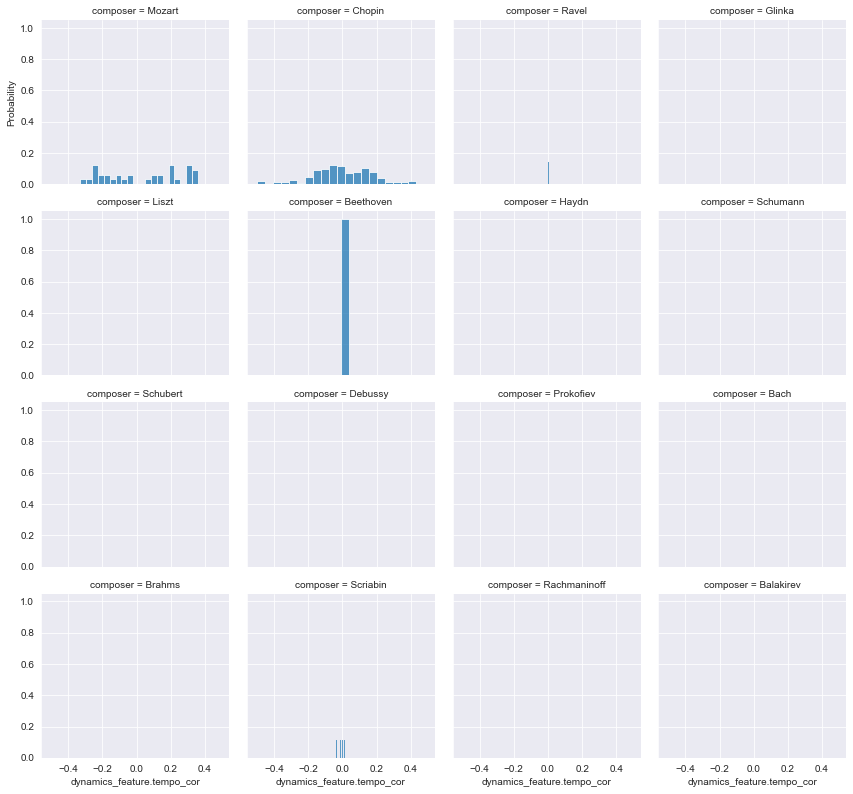

In [12]:
plot_by_dataset(dataset="ASAP", attri=all_features[8], level="piece")

##### Is the tempo-dynamics coupling more prominent within phrases? 

Suggestions: 
* loudness from velocity - at least test a small section of audio
* effect of window
* effect on voices
* Start from senario - retrieve from data

Observation from the Schubert (p13):
* smaller window shows more fluctuation but more prominent peaks as well, and majority of the time the correlation is below 0. (for w=3, mean correlation =-0.22)
* the larger the window, the higher the overall correlation
* peaks are similar for max <--> mean, but max has more significant value
* peaks are similar across windows 

Schubert (all pianists):
* common prominent place: beat 3, 69, 90
* 

[(13.0, 0.015385416), (19.5, -0.08462301), (58.0, -0.029905936), (73.5, 0.27481088)]


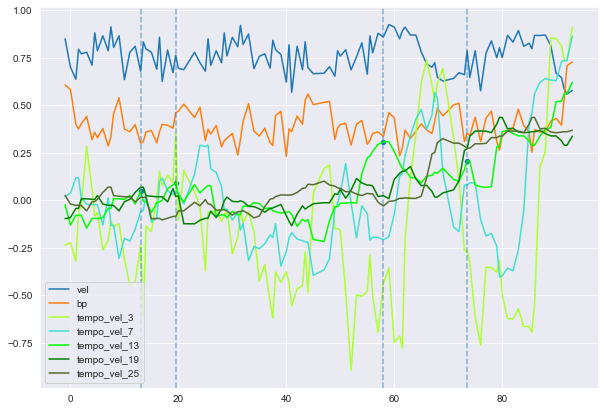

In [52]:
pianist = "p13"
score = pt.load_musicxml("../Datasets/vienna4x22/musicxml/Schubert_D783_no15.musicxml")
performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Schubert_D783_no15_{pianist}.mid")
performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Schubert_D783_no15_{pianist}.match")

agg = "max"

# m_score, unique_onset_idxs = pt.musicanalysis.compute_matched_score(score, performance, alignment)
# df = pt.musicanalysis.dynamics_feature(m_score, unique_onset_idxs, performance, w=9, agg=agg)

parameters, snote_ids = pt.musicanalysis.encode_performance(score, performance, alignment)
pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions='all')
avg_vel, m_score, unique_onset_idxs = res['avg_vel'], res['m_score'], res['unique_onset_idxs']
# # pf, meta_data = load_dataset_pf("VIENNA422", return_metadata=True)
N = len(unique_onset_idxs)
x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]

sns.lineplot(x=x, y=avg_vel / 127, label="vel")
sns.lineplot(x=x, y=parameters['beat_period'][[idxs[0] for idxs in unique_onset_idxs]], label="bp")

palette = sns.color_palette("mako_r", 6)
for window, c in zip([3, 7, 13, 19, 25], ["greenyellow", "turquoise", "lime", "green", "darkolivegreen"]):
    pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions='all', w=window)
    avg_vel = res['avg_vel']
    y = pf['dynamics_feature.tempo_cor'][[idxs[0] for idxs in unique_onset_idxs]]
    sns.lineplot(x=x, y=y, label=f"tempo_vel_{window}", color=c)
    
    if window == 13:
        peaks, _ = find_peaks(y, prominence=0.1)
        peak_timepoints = x[peaks]
        sns.scatterplot(peak_timepoints, y[peaks])
        for tm in peak_timepoints:
            plt.axvline(tm, alpha=0.5, linestyle="--")
print(list(zip(peak_timepoints, y[peaks])))

# plt.xlim(0, 80)
# plt.legend()

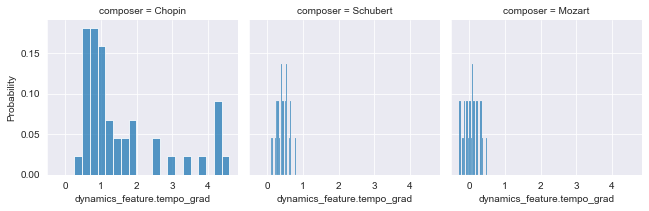

In [ ]:
plot_by_dataset(dataset="VIENNA422", attri=all_features[8], level="piece")

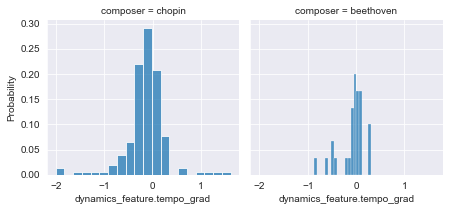

In [ ]:
plot_by_dataset(dataset="BMZ", attri=all_features[8])

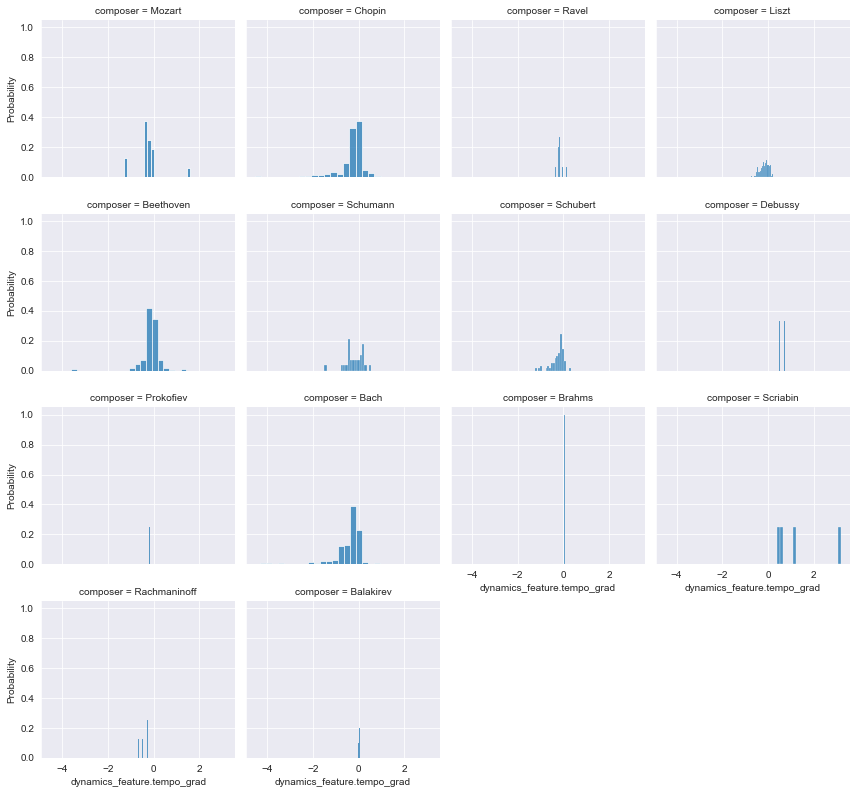

In [ ]:
plot_by_dataset(dataset="ASAP", attri=all_features[8], filter=['Haydn', 'Glinka'])

### How salient is Melody lead? What about bass?

Overall very strong relationship between higher pitch and earlier notes, but there is still a composition difference. Notably Bach is the one that's more evenly distributed. 

Observation in Schubert (p13):
* negative correlation peaks:  beat 9, 14, 19, 25, 31, 34, 43, 51, 72, 75. There are roughly two categories that contributes to their negative correlation: 1. No melody note on beat, so for the chord-only beat, it's the case that bass goes earlier. 2. Significant downbeat where  

Observation cross pianists:
* Common neg-cor-peaks by averaging \ interpolating everyone: 48 (-0.26), 54 (-0.43), 72 (-0.19), 78 (-0.48). Interestingly, these corresponds with the four marcarto beat in the piece.
* The most positive place? There are two places that exhibits top correlation of 1 (agreed by all pianists!): Beat 64 and beat 88. 
<!-- 
#### Are there cases where bass is leading?

* melody lead <-> chord. But without chord maybe not. Check joint onset -> check by staff and look for the loudest note in each - if the lowest note is the loudest in the left range.  -->

[(4.0, 0.26611817), (8.0, 0.3576723), (13.0, 0.71458775), (17.0, 0.55261517), (19.0, -0.636324), (26.0, 0.82477623), (32.0, -0.6202985), (37.0, 0.5903301), (41.0, 0.8019357), (43.0, 0.6586039), (50.0, 0.57589084), (52.0, -0.24709474), (58.0, 0.007097502), (61.5, 0.24480963), (63.0, 0.34453532), (65.0, 0.8784465), (68.0, 0.042352773), (74.0, 0.5337246), (77.0, 0.40014997), (80.0, 0.6107567), (82.0, 0.6318466), (86.0, 0.3049572), (92.0, 0.74061066)]


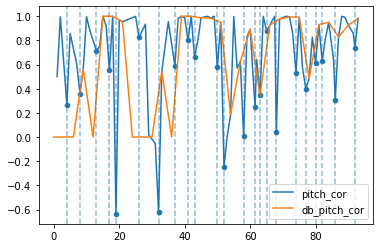

In [20]:
pianist = "p03"
score = pt.load_musicxml("../Datasets/vienna4x22/musicxml/Schubert_D783_no15.musicxml")
performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Schubert_D783_no15_{pianist}.mid")
performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Schubert_D783_no15_{pianist}.match")

pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
parameters, snote_ids = pt.musicanalysis.encode_performance(score, performance, alignment)
N = len(unique_onset_idxs)
x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]
y = pf['asynchrony_feature.pitch_cor'][[idxs[0] for idxs in unique_onset_idxs]]

filtered_y = y[y != 0]
filtered_x = x[y != 0]
sns.lineplot(x=filtered_x, y=filtered_y, label="pitch_cor")

downbeat_x = x[x % 3 == 0]
downbeat_y = y[x % 3 == 0]
sns.lineplot(x=downbeat_x, y=downbeat_y, label="db_pitch_cor")

peaks, _ = find_peaks(-filtered_y, prominence=0.1)
peak_timepoints = filtered_x[peaks]
sns.scatterplot(peak_timepoints, filtered_y[peaks])
for tm in peak_timepoints:
    plt.axvline(tm, alpha=0.5, linestyle="--")

print(list(zip(peak_timepoints, filtered_y[peaks])))

# print(m_score[155:165])
# print(m_score.dtype)


[(4.0, 0.14748096), (7.0, 0.22691295), (9.0, 0.051158488), (15.0, 0.25), (19.0, -0.18553641), (25.0, 0.5258518), (28.0, 0.43867677), (33.0, 0.064798586), (37.0, 0.34454337), (39.0, 0.2), (43.0, -0.17329656), (48.0, -0.2646803), (51.0, 0.007910815), (54.0, -0.43521532), (57.0, -0.056353986), (61.0, 0.025411298), (63.0, 0.4074563), (66.0, 0.38186914), (68.0, 0.25265723), (72.0, -0.1928588), (75.0, 0.02739885), (78.0, -0.42713588), (81.0, 0.0048788874), (85.0, 0.028718919), (87.0, 0.12888744), (90.0, 0.51712227), (92.0, 0.4207074)]


Text(0, 0.5, 'correlation')

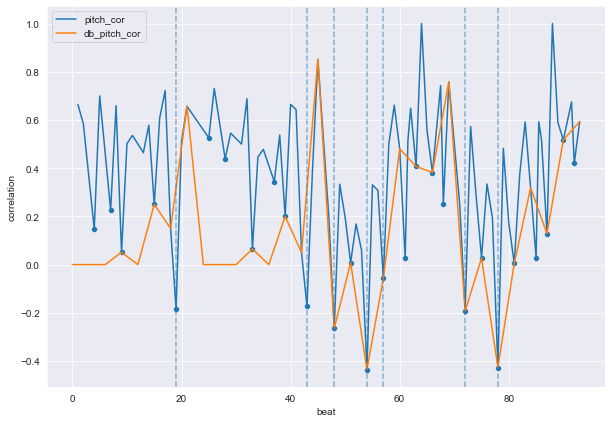

In [11]:
plt.rcParams['figure.figsize'] = [10, 7]

y_total = []

score = pt.load_musicxml("../Datasets/vienna4x22/musicxml/Schubert_D783_no15.musicxml")
performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Schubert_D783_no15_p13.mid")
performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Schubert_D783_no15_p13.match")

pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
default_x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]

for pianist in range(1, 21):
    pianist = str(pianist).zfill(2)
    score = pt.load_musicxml("../Datasets/vienna4x22/musicxml/Schubert_D783_no15.musicxml")
    performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Schubert_D783_no15_p{pianist}.mid")
    performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Schubert_D783_no15_p{pianist}.match")

    pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
    unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
    parameters, snote_ids = pt.musicanalysis.encode_performance(score, performance, alignment)
    N = len(unique_onset_idxs)
    x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]
    y = pf['asynchrony_feature.pitch_cor'][[idxs[0] for idxs in unique_onset_idxs]]
    y_interp = interp1d(x, y)(default_x)
    y_total.append(y_interp)

sns.set_style("darkgrid")
y = np.array(y_total).mean(0)
filtered_y = y[y != 0]
filtered_x = x[y != 0]
sns.lineplot(x=filtered_x, y=filtered_y, label="pitch_cor")

downbeat_x = x[x % 3 == 0]
downbeat_y = y[x % 3 == 0]
sns.lineplot(x=downbeat_x, y=downbeat_y, label="db_pitch_cor")

peaks, _ = find_peaks(-filtered_y, prominence=0.1)
peak_timepoints = filtered_x[peaks]
sns.scatterplot(peak_timepoints, filtered_y[peaks])
for peak in (peaks):
    if filtered_y[peak] < 0:
        plt.axvline(filtered_x[peak], alpha=0.5, linestyle="--")

print(list(zip(peak_timepoints, filtered_y[peaks])))
plt.xlabel("beat")
plt.ylabel("correlation")

# print(m_score[155:165])
# print(m_score.dtype)


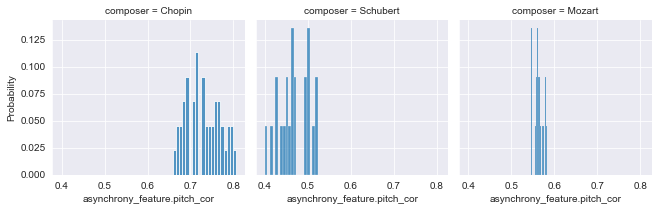

In [ ]:
plot_by_dataset(dataset="VIENNA422", attri=all_features[2], level="piece")

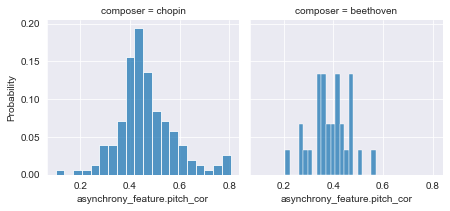

In [ ]:
plot_by_dataset(dataset="BMZ", attri=all_features[2], level="piece")

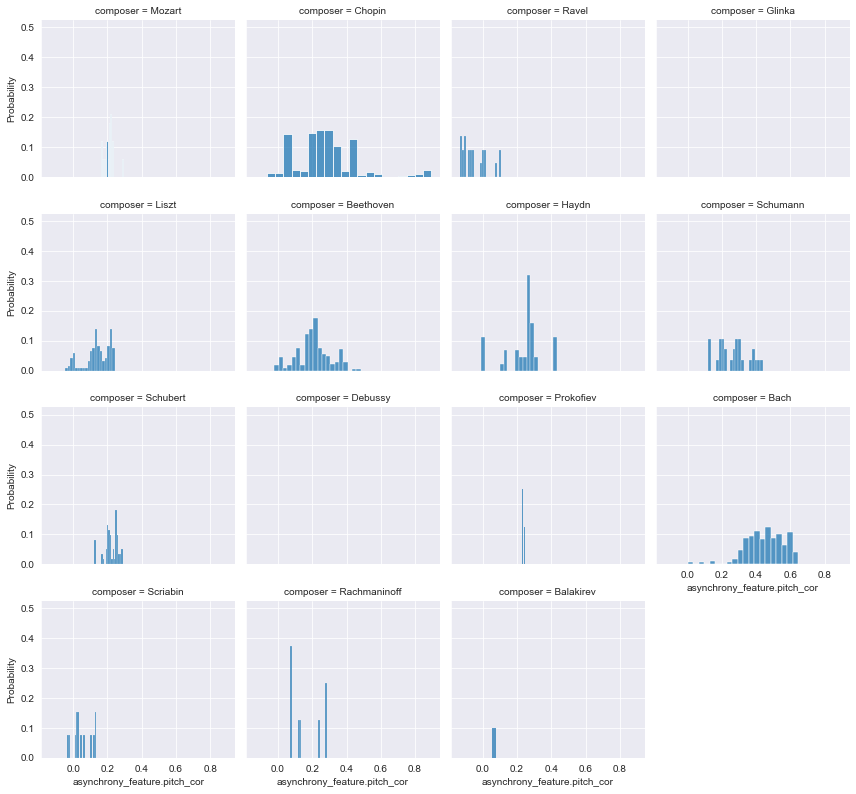

In [ ]:
plot_by_dataset(dataset="ASAP", attri=all_features[2], level="piece", filter=['Brahms'])

### Pedal

The release of pedal time regarding note events are measured in seconds. The to_prev_release time is generally longer than the to_next_release time. The difference between composer is also prominent, that romantic music tends to have longer holds of the pedal.

* Overall pedal usage
* compare chord / key changes - taking windows of pitch profiles 

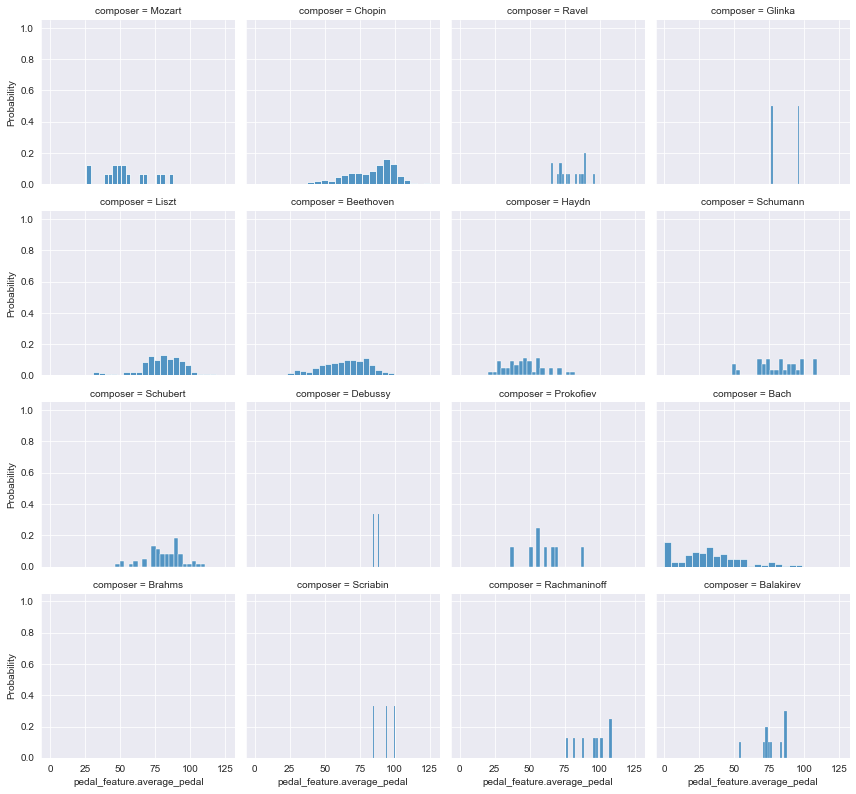

In [8]:
plot_by_dataset(dataset="ASAP", attri=all_features[-2], level="piece")

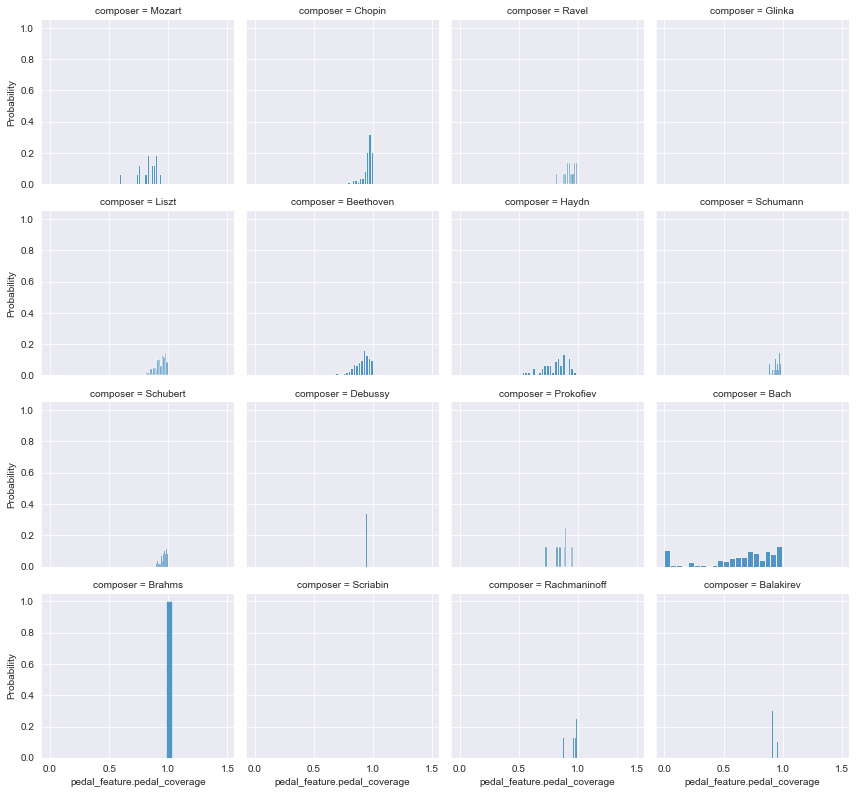

In [9]:
plot_by_dataset(dataset="ASAP", attri=all_features[-1], level="piece")

ASAP 0.8712621331214905


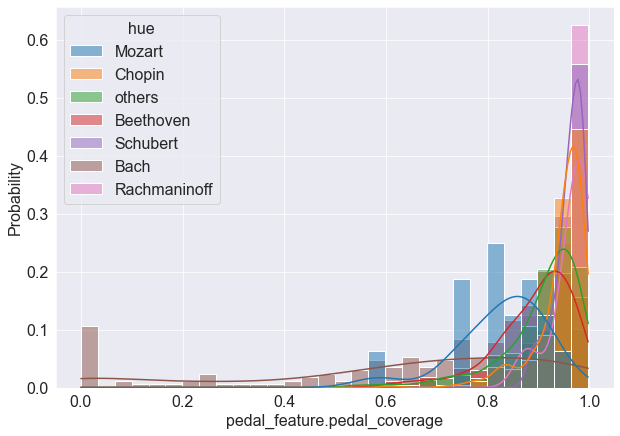

In [57]:
# plot_datasets(datasets=["VIENNA422"], attri=all_features[-1])
plot_datasets(datasets=["ASAP"], attri=all_features[-1], selected_hue=['Mozart', 'Chopin', 'Beethoven', 'Rachmaninoff', 'Schubert', 'Bach'])

ASAP 67.05475616455078


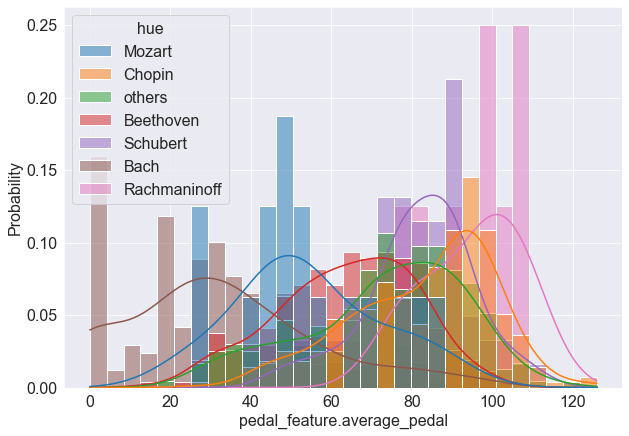

In [62]:
# plot_datasets(datasets=["VIENNA422"], attri=all_features[-2])
# plot_datasets(datasets=["VIENNA422"], attri=all_features[-2])
plot_datasets(datasets=["ASAP"], attri=all_features[-2], selected_hue=['Mozart', 'Chopin', 'Beethoven', 'Rachmaninoff', 'Schubert', 'Bach'])

In [3]:
# get all pedal summarization in ATEPP dataset
import glob
from scipy.integrate import quad
def pedal_feature(performance):
    """
    Compute the pedal features. 

    Repp: Pedal Timing and Tempo in Expressive Piano Performance: A Preliminary Investigation
        How pedal timing adjust to the IOI variations. 

    Parameters
    ----------
    m_score : list
        correspondance between score and performance notes, with score markings. 
    unique_onset_idxs : list
        a list of arrays with the note indexes that have the same onset
    performance: PerformedPart
        The original PerformedPart object
        
    Returns
    -------
    pedal_ : structured array (4, n_notes) with fields
        onset_value [0, 127]: The interpolated pedal value at the onset
        offset_value [0, 127]: The interpolated pedal value at the key offset
        to_prev_release [0, 10]: delta time from note onset to the previous pedal release 'peak'
        to_next_release [0, 10]: delta time from note offset to the next pedal release 'peak'
        average_pedal [0, 127]: integral of the time-pedal curve, divided by duration, piece level (one value)
        pedal_coverage [0, 1]: the percentage of notes being covered by pedal above 
            the threshold (default 10), piece level
    """  
    
    ramp_func, final_time = pedal_ramp(performance.performedparts[0])

    x = np.linspace(0, final_time, 500)
    y = ramp_func(x)

    # average
    res = quad(ramp_func, -np.inf, np.inf)
    average_pedal = (res[0] / final_time) if final_time else 0 
    
    # coverage
    indices_greater_than_10 = np.where(ramp_func(x) > 10)[0]
    step_size = final_time / 500
    continuous_duration = len(indices_greater_than_10) * step_size
    pedal_coverage = (continuous_duration / final_time) if final_time else 0 

    features = rfn.merge_arrays([average_pedal, pedal_coverage], flatten=True, usemask=False)
    return {"features": features}

def pedal_ramp(ppart):
    """Pedal ramp in the same shape as the m_score.

    Returns:
    * pramp : a ramp function that ranges from 0
                  to 127 with the change of sustain pedal
    """
    pedal_controls = ppart.controls

    timepoints = [control['time'] for control in pedal_controls]
    values = [control['value'] for control in pedal_controls]

    if len(timepoints) <= 1: # the case there is no pedal
        timepoints, values = [0, 0], [0, 0]

    agg_ramp_func = interp1d(timepoints, values, bounds_error=False, fill_value=0)

    return agg_ramp_func, timepoints[-1]



alignment_paths = glob.glob(os.path.join(ATEPP_DIR, "**/*_match.txt"), recursive=True)
performance_paths = glob.glob(os.path.join(ATEPP_DIR, "**/*[0-9].mid"), recursive=True)

# for p_path in tqdm(performance_paths):

#     performance = pt.load_performance(p_path)
#     pedal_features = pedal_feature(performance)

#     print(pedal_features)
#     np.save(f"{p_path[:-4]}_perf_features.npy", pedal_features) 
        

  0%|          | 2/11716 [00:00<13:48, 14.14it/s]

{'features': array([(30.84482967, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(33.4481475, 0.822)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(43.55326782, 0.828)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 6/11716 [00:00<15:04, 12.94it/s]

{'features': array([(43.69191079, 0.842)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(41.73125304, 0.814)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.06061887, 0.816)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 8/11716 [00:00<14:31, 13.44it/s]

{'features': array([(35.54465237, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.08505763, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(36.63824531, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 10/11716 [00:00<14:16, 13.66it/s]

{'features': array([(33.25928674, 0.814)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(37.9796186, 0.828)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 12/11716 [00:01<18:12, 10.71it/s]

{'features': array([(38.82342243, 0.82)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 14/11716 [00:01<26:22,  7.39it/s]

{'features': array([(35.517163, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(40.54447654, 0.818)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 17/11716 [00:01<24:20,  8.01it/s]

{'features': array([(36.10060547, 0.816)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(27.00641092, 0.862)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(32.8568233, 0.826)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 19/11716 [00:02<23:46,  8.20it/s]

{'features': array([(24.18759806, 0.836)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(36.29544195, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 20/11716 [00:02<24:52,  7.84it/s]

{'features': array([(40.78260564, 0.796)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(26.71515466, 0.816)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 23/11716 [00:02<27:11,  7.17it/s]

{'features': array([(28.81496736, 0.838)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(49.88958214, 0.88)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 24/11716 [00:02<29:03,  6.71it/s]

{'features': array([(25.10836608, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 26/11716 [00:03<32:44,  5.95it/s]

{'features': array([(38.3709384, 0.826)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(43.71288277, 0.866)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 28/11716 [00:03<31:52,  6.11it/s]

{'features': array([(42.65039591, 0.83)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.48677327, 0.822)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 30/11716 [00:03<35:28,  5.49it/s]

{'features': array([(46.63845728, 0.834)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(43.62955854, 0.87)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 32/11716 [00:04<35:12,  5.53it/s]

{'features': array([(25.56962137, 0.83)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(41.6894278, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 33/11716 [00:04<34:47,  5.60it/s]

{'features': array([(22.08544091, 0.848)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 35/11716 [00:04<36:27,  5.34it/s]

{'features': array([(33.73789054, 0.796)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.51417039, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 37/11716 [00:05<35:55,  5.42it/s]

{'features': array([(33.18701485, 0.852)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(42.40505962, 0.81)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 39/11716 [00:05<35:56,  5.41it/s]

{'features': array([(40.61036776, 0.828)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(31.09474665, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 41/11716 [00:05<34:54,  5.58it/s]

{'features': array([(28.03903205, 0.818)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(60.60638565, 0.878)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 43/11716 [00:06<37:23,  5.20it/s]

{'features': array([(45.46574406, 0.842)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(39.82021441, 0.826)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 45/11716 [00:06<35:34,  5.47it/s]

{'features': array([(40.42207204, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(40.5531254, 0.81)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 48/11716 [00:06<24:04,  8.08it/s]

{'features': array([(42.28780122, 0.842)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.29649204, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(42.11941209, 0.87)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 52/11716 [00:07<16:37, 11.69it/s]

{'features': array([(26.06471537, 0.744)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(24.04127494, 0.82)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(30.1908045, 0.784)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(28.73749508, 0.802)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 54/11716 [00:07<15:15, 12.74it/s]

{'features': array([(28.76067224, 0.802)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(25.62146451, 0.796)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(29.67705976, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 56/11716 [00:07<16:15, 11.95it/s]

{'features': array([(36.29785608, 0.834)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(31.60707366, 0.842)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 58/11716 [00:07<19:17, 10.07it/s]

{'features': array([(41.50553915, 0.826)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.96590511, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 61/11716 [00:08<22:30,  8.63it/s]

{'features': array([(28.19336371, 0.82)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(33.72398665, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 63/11716 [00:08<23:45,  8.17it/s]

{'features': array([(32.89187128, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.78321947, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 66/11716 [00:08<20:20,  9.54it/s]

{'features': array([(32.08163135, 0.83)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(40.51064813, 0.87)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.97101308, 0.876)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 69/11716 [00:09<19:15, 10.08it/s]

{'features': array([(36.86269644, 0.856)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(26.45080243, 0.886)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(33.45264727, 0.854)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 71/11716 [00:09<17:48, 10.90it/s]

{'features': array([(38.21239981, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(39.51544992, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.62104541, 0.862)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 75/11716 [00:09<16:37, 11.67it/s]

{'features': array([(41.88603624, 0.848)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(72.35074716, 0.88)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(46.8113482, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 77/11716 [00:09<21:58,  8.83it/s]

{'features': array([(35.62972781, 0.832)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.80005822, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 79/11716 [00:10<23:31,  8.25it/s]

{'features': array([(33.12793225, 0.838)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(23.66658095, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 81/11716 [00:10<25:40,  7.55it/s]

{'features': array([(39.82822633, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(41.80484727, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 83/11716 [00:10<29:27,  6.58it/s]

{'features': array([(35.49642938, 0.864)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.91153225, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 85/11716 [00:11<28:59,  6.69it/s]

{'features': array([(36.39959603, 0.822)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(41.62640999, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 88/11716 [00:11<22:42,  8.53it/s]

{'features': array([(39.18420133, 0.828)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(33.55588393, 0.856)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(39.69486202, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 90/11716 [00:11<25:05,  7.72it/s]

{'features': array([(37.64578056, 0.822)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(37.92806689, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


KeyboardInterrupt: 

In [ ]:
pf, meta_dict = load_dataset_pf(datasets=['ATEPP'], return_metadata=True)

In [42]:
pf[1].shape == ()

True

ATEPP 33.297072360184245


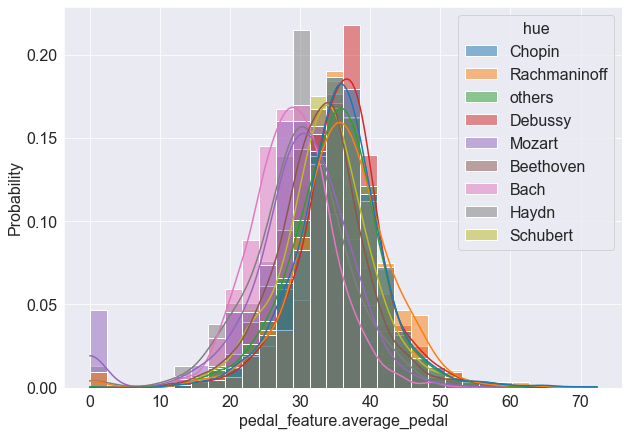

In [76]:
plot_datasets(datasets=["ATEPP"], attri=all_features[-2], 
              selected_hue=['Mozart', 'Chopin', 'Beethoven', 'Rachmaninoff', 
                            'Schubert', 'Bach', 'Debussy', 'Haydn'],
              pf=pf,
              meta_dict=meta_dict
              )

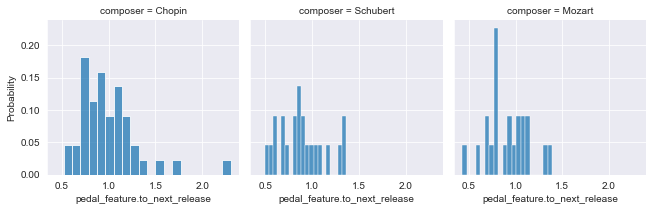

In [ ]:
plot_by_dataset(dataset="VIENNA422", attri=all_features[12], level="piece")

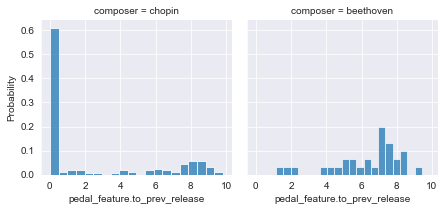

In [ ]:
plot_by_dataset(dataset="BMZ", attri=all_features[11], level="piece")

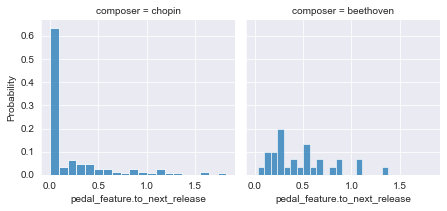

In [ ]:
plot_by_dataset(dataset="BMZ", attri=all_features[12], level="piece")

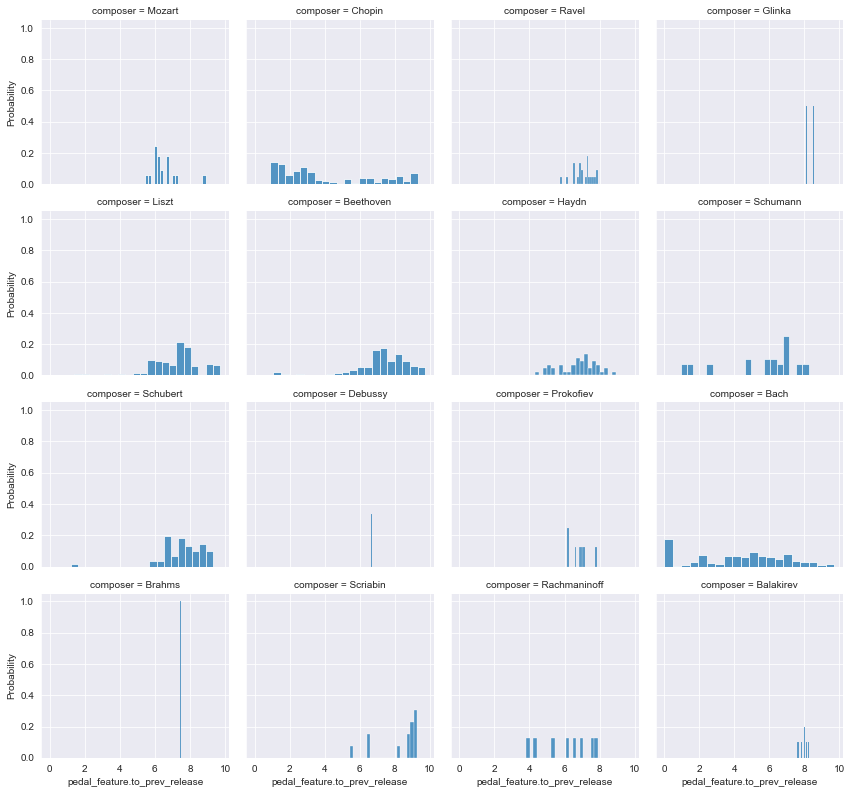

In [ ]:
plot_by_dataset(dataset="ASAP", attri=all_features[11], level="piece")

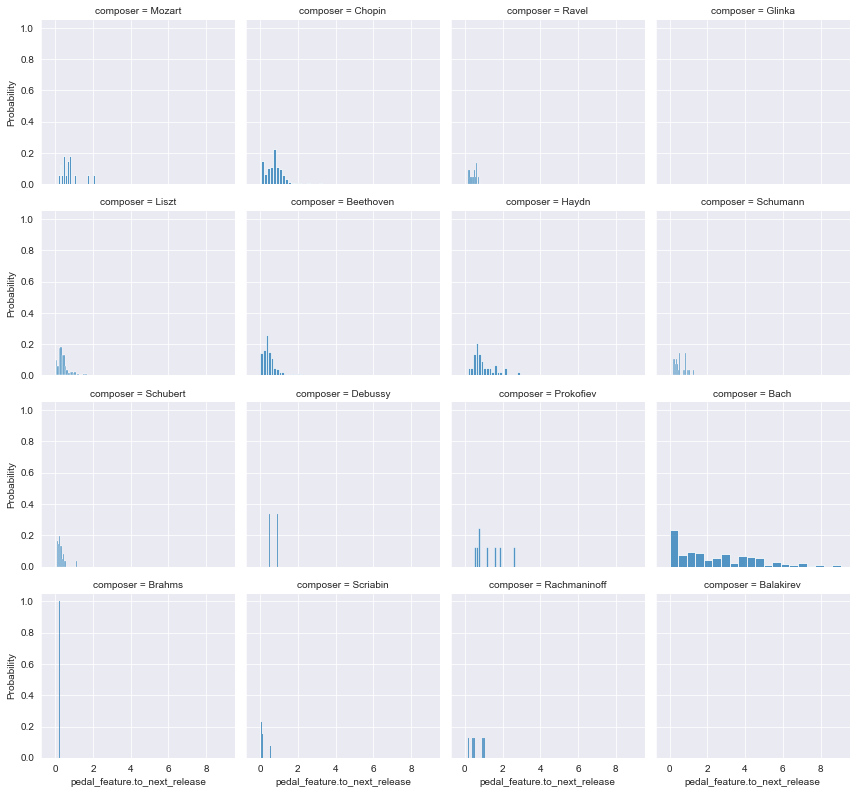

In [ ]:
plot_by_dataset(dataset="ASAP", attri=all_features[12], level="piece")

### Two consonant tones overlapped more than two dissonant tones?

In [42]:
plot_by_dataset(dataset="ASAP", attri=all_features[0], level="piece")

NameError: name 'plot_by_dataset' is not defined